In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import os

2024-06-21 21:29:22.639206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 21:29:22.639241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 21:29:22.640381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 21:29:22.647500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 21:29:23.452008: W tensorflow/comp

## data loading and preprocessing

In [2]:
# load data into dataframe

df = pd.read_csv('data/BTC-USD-15-MIN.csv', parse_dates=['Datetime'])

df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)

# remove timezone info
df['Datetime'] = df['Datetime'].dt.tz_convert(None)

df.set_index('Datetime', inplace=True)

In [3]:
# inspect data

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8721 entries, 2021-09-27 13:45:00 to 2021-12-29 13:50:02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8721 non-null   float64
 1   High       8721 non-null   float64
 2   Low        8721 non-null   float64
 3   Close      8721 non-null   float64
 4   Adj Close  8721 non-null   float64
 5   Volume     8721 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 476.9 KB


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-09-27 13:45:00,43443.062500,43555.515625,43443.062500,43548.773438,43548.773438,50628608
2021-09-27 14:00:00,43547.558594,43616.171875,43482.406250,43567.480469,43567.480469,54437888
2021-09-27 14:15:00,43557.968750,43656.312500,43485.089844,43631.105469,43631.105469,45457408
2021-09-27 14:30:00,43632.500000,44027.242188,43353.429688,43443.820312,43443.820312,302301184
2021-09-27 14:45:00,43425.750000,43485.988281,43186.468750,43186.468750,43186.468750,14149632


In [4]:
# check for missing values

df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# select close price
close_prices = df['Close'].values.reshape(-1, 1)

# normalize the close price data
scaler = MinMaxScaler()
close_price_scaled = scaler.fit_transform(close_prices)

## set tf.data.Dataset for model inputs

In [6]:
# create dataset

print("creating dataset...")
def create_dataset(data, time_steps=96):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(x), np.array(y)

time_steps = 96  # 24 hours of 15 minute data
X, y = create_dataset(close_price_scaled, time_steps)


creating dataset...


In [7]:
# split into train and test sets

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## set up tf.data.Dataset

In [8]:
# convert data to tf.data.Dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


2024-06-21 21:29:25.511273: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
# batch and prefetch

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## model architecture

In [10]:
print("Creating model...")
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Creating model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 96, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## model training

In [11]:
print("Training model...")
history = model.fit(
    train_dataset, 
    epochs=20, 
    validation_data=test_dataset, 
    verbose=1
)

Training model...
Epoch 1/20
216/216 [==============================] - 11s 45ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2/20
216/216 [==============================] - 9s 44ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/20
216/216 [==============================] - 9s 43ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 4/20
216/216 [==============================] - 9s 44ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/20
216/216 [==============================] - 9s 43ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 6/20
216/216 [==============================] - 9s 43ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 7/20
216/216 [==============================] - 9s 44ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 8/20
216/216 [==============================] - 9s 43ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 9/20
216/216 [==============================] - 9s 43ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/20
216/216 [==============================] - 9s 44ms/step - lo

In [12]:
# save model

model.save('btc_forecasting_model.h5')
print("Model saved as 'btc_forecasting_model.h5'")

Model saved as 'btc_forecasting_model.h5'


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## evaluation

In [13]:
print("Evaluating model...")
train_loss = model.evaluate(train_dataset)
test_loss = model.evaluate(test_dataset)
print(f"Train MSE: {train_loss:.4f}")
print(f"Test MSE: {test_loss:.4f}")

Evaluating model...
54/54 [==============================] - 1s 12ms/step - loss: 8.6862e-04
Train MSE: 0.0491
Test MSE: 0.0009


In [14]:
# make predictions

predictions = model.predict(test_dataset)

54/54 [==============================] - 1s 12ms/step


In [15]:
# inverse transform predictions and actual values

# reshape y_test to a 2D array
y_test_2d = y_test.reshape(-1, 1)

predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test_2d)

In [16]:
# calculate MAE and RMSE

mae = np.mean(np.abs(predictions - y_test_inv))
rmse = np.sqrt(np.mean((predictions - y_test_inv)**2))
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Square Error: {rmse:.2f}")

Mean Absolute Error: 667.49
Root Mean Square Error: 817.21


## visualization

Generating visualizations...


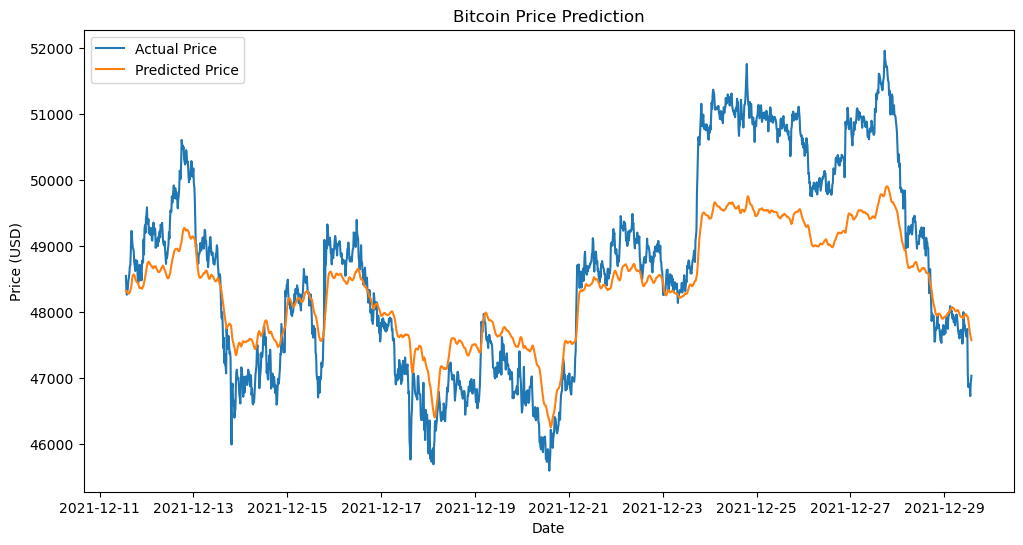

In [17]:
print("Generating visualizations...")
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual Price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('btc_price_prediction.png')

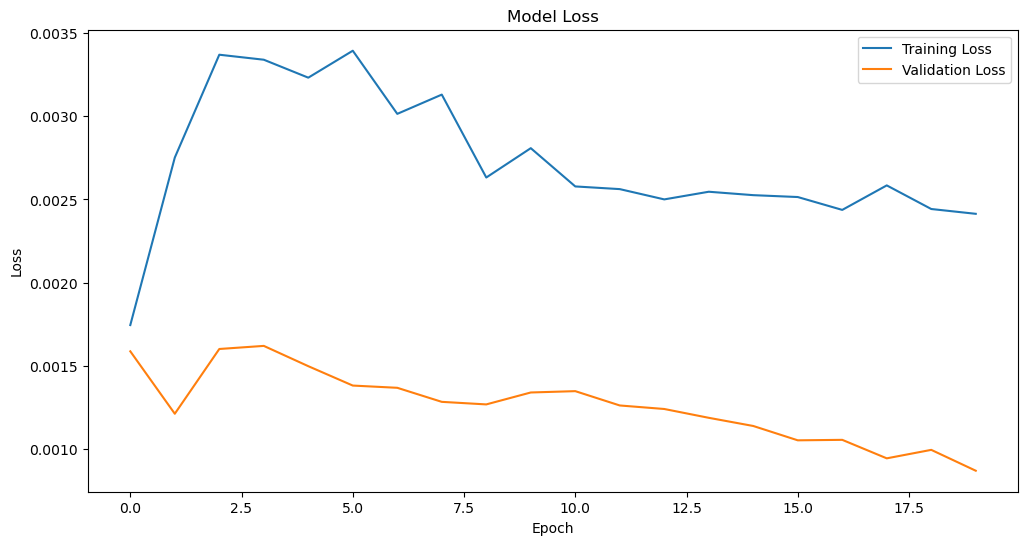

visualizations saved to 'btc_price_prediction.png' and 'model_loss.png'


In [18]:
# plot training history

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model_loss.png')
plt.show()
print("visualizations saved to 'btc_price_prediction.png' and 'model_loss.png'")

In [19]:
# make future predictions (for the next 96 steps = 24 hours)

def predict_future(model, last_sequence, num_steps):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(num_steps):
        # Reshape the current_sequence to match the model's input shape
        current_sequence_reshaped = current_sequence.reshape(1, time_steps, 1)
        # Make a prediction
        prediction = model.predict(current_sequence_reshaped)
        # Append the prediction to our results
        future_predictions.append(prediction[0, 0])
        # Update the sequence with the new prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = prediction
    
    return np.array(future_predictions)


last_sequence = X_test[-1]
future_normalized = predict_future(model, last_sequence, 96)
future_prices = scaler.inverse_transform(future_normalized.reshape(-1, 1))

1/1 [==============================] - 0s 20ms/step


## plot future predictions

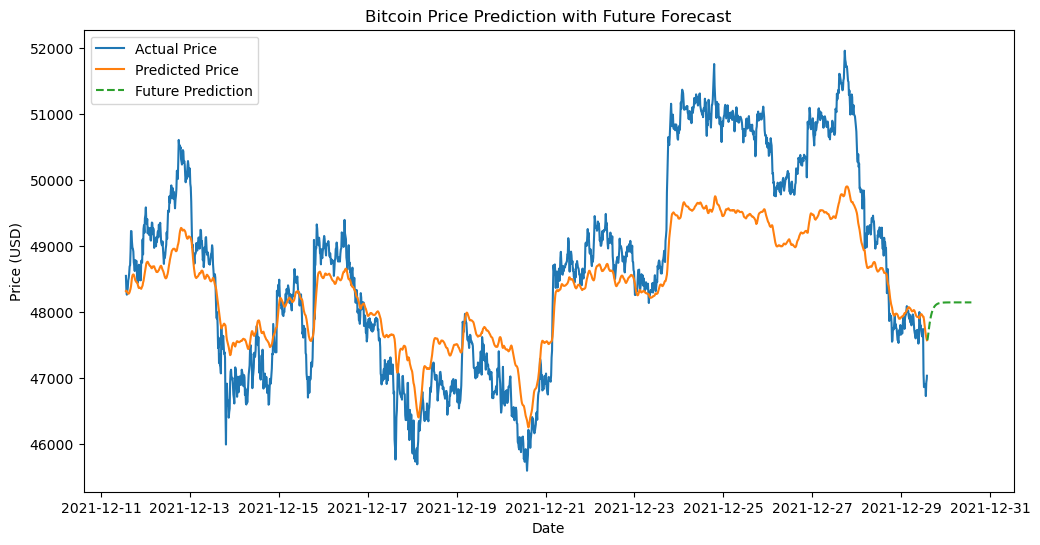

visualization of future prediction saved as 'btc_price_prediction_with_forecast.png'


In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual Price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Price')
future_dates = pd.date_range(start=df.index[-1], periods=97, freq='15T')[1:]
plt.plot(future_dates, future_prices, label='Future Prediction', linestyle='--')
plt.title('Bitcoin Price Prediction with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('btc_price_prediction_with_forecast.png')
plt.show()

print("visualization of future prediction saved as 'btc_price_prediction_with_forecast.png'")

In [21]:
print("\nDataset Statistics:")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nPrice range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
print(f"Date range: {df.index.min()} - {df.index.max()}")


Dataset Statistics:
Total samples: 8721
Training samples: 6900
Testing samples: 1725

Price range: $40935.96 - $68664.16
Date range: 2021-09-27 13:45:00 - 2021-12-29 13:50:02


In [22]:
# save predictions to CSV

results_df = pd.DataFrame({
    'Datetime': df.index[-len(y_test):],
    'Actual': y_test_inv.flatten(),
    'Predicted': predictions.flatten()
})
results_df.to_csv('btc_predictions.csv', index=False)
print("Predictions saved to 'btc_predictions.csv'")

print("\nScript execution completed successfully!")

Predictions saved to 'btc_predictions.csv'

Script execution completed successfully!
